----
----
# <b><center>Audio signal analysis, indexing and transformation</center></b>
# <b><center>TP5: High resolution methods; Analysis and Synthesis of bell sounds</center></b>
# <b>Matteo MARENGO | matteo.marengo@ens-paris-saclay.fr</b>
# <b>MVA 2023-2024 - ENS Paris Saclay </b>
----
----

# <b> Import libraries </b>

In [103]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import IPython

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
from scipy.io.wavfile import write
from scipy import signal
#import scipy.io.wavfile
from scipy.linalg import hankel
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3

----
----
# <b>Useful functions</b>

In [104]:
def load_sound(file):
    return wave.open(file, 'rb')

def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    plt.figure(figsize=(w, h))
    plt.plot(times,x.reshape(len_x))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [105]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

----
----
# <b>Open audio file</b>

In [106]:
wavefile = load_sound('ClocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [107]:
IPython.display.Audio('ClocheB.WAV')

In [108]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

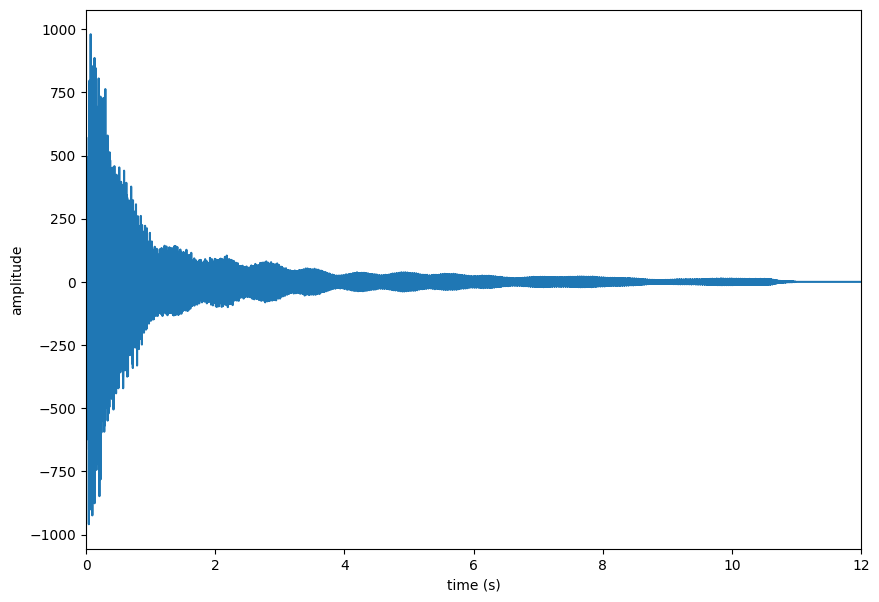

In [109]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

In [110]:
write('new_bell.wav', Fs, np.array(x.reshape(len_x), dtype=np.int16)) # to write a new wave file

----
----
# <b> 3. Synthetic signal </b>

## <b>3.1. Spectral analysis by Fourier transform

### <b> Synthetize the sound </b>

In [111]:
# First step is to synthesize the sound
N = 63
delta=np.array([0,-0.05])
f = np.array([0.25,0.25+1/63])
a = np.array([1,10])
phi = np.random.uniform(-np.pi, np.pi, size=2)
# synthetize the sound
x = Synthesis(N,delta,f,a,phi)

### <b> Observe the periodogram of the signal </b>

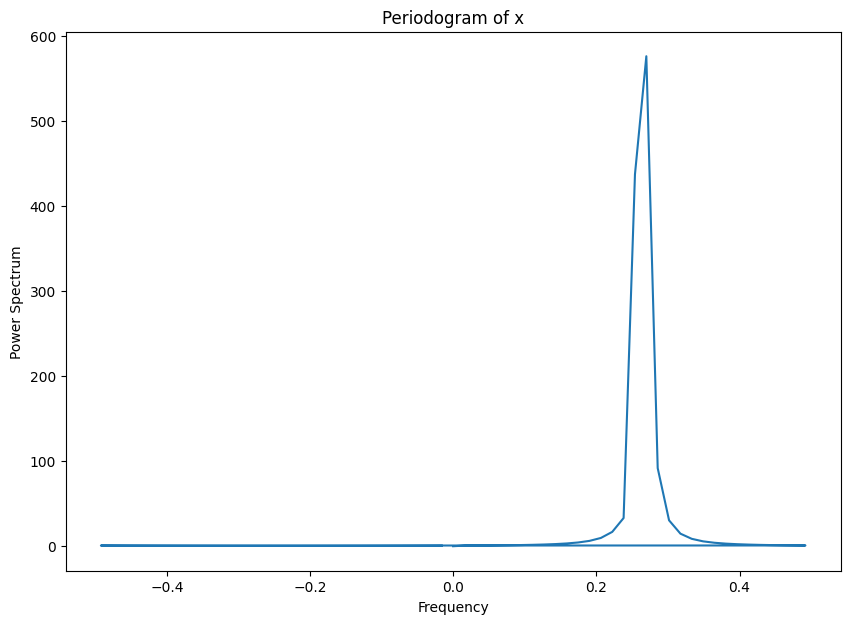

In [112]:
frequencies, power_spectrum = signal.periodogram(x, 1)

plt.figure(figsize=(10, 7))
plt.plot(frequencies, power_spectrum)
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')
plt.title('Periodogram of x')
plt.show()


- On this periodogram we observe that at the frequency 0.25 Hz, the power spectrum is important.

### <b> Study the separability of the two spectral lines </b>

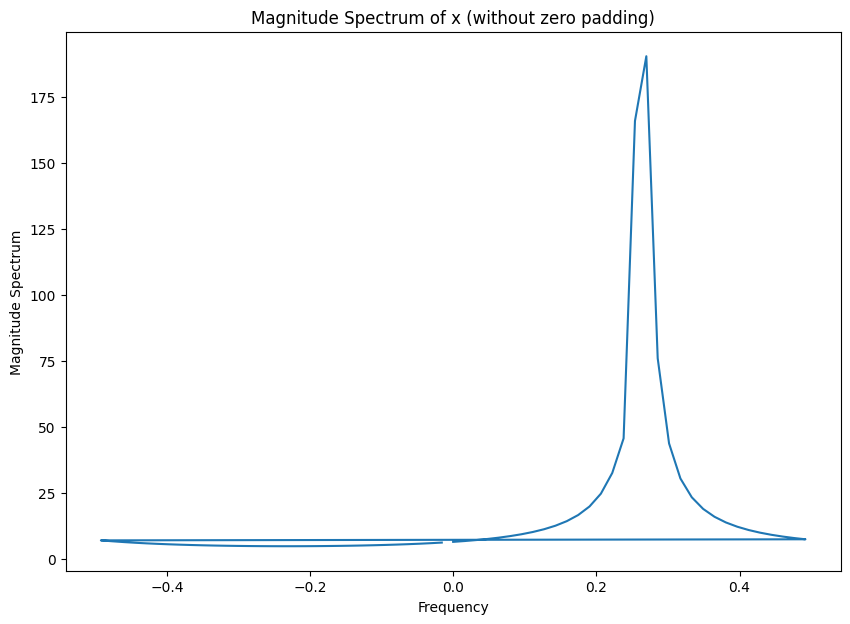

In [113]:
X = np.fft.fft(x, N)
frequencies = np.fft.fftfreq(N, 1)

plt.figure(figsize=(10, 7))
plt.plot(frequencies, np.abs(X))
plt.xlabel('Frequency')
plt.ylabel('Magnitude Spectrum')
plt.title('Magnitude Spectrum of x (without zero padding)')
plt.show()


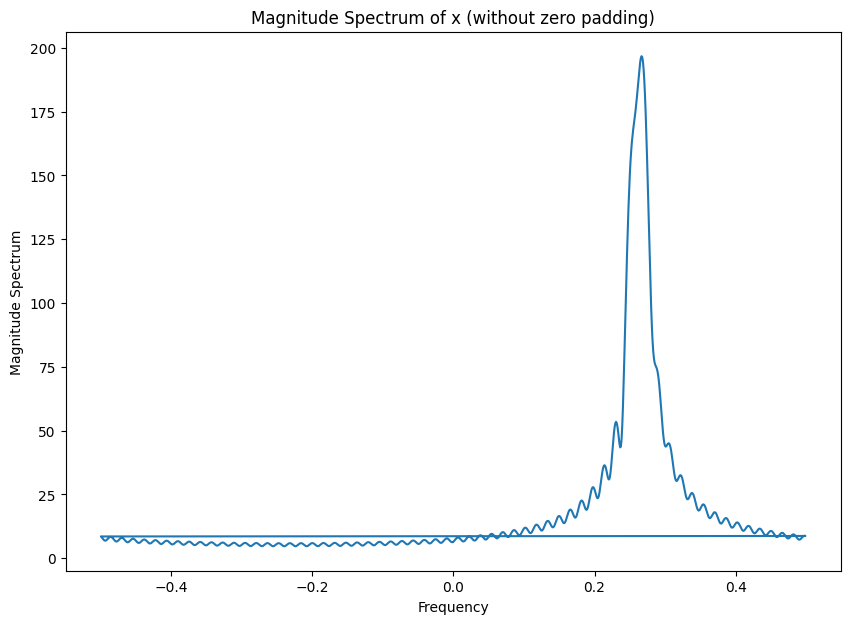

In [114]:
X = np.fft.fft(x, 1024)
frequencies = np.fft.fftfreq(1024, 1)

plt.figure(figsize=(10, 7))
plt.plot(frequencies, np.abs(X))
plt.xlabel('Frequency')
plt.ylabel('Magnitude Spectrum')
plt.title('Magnitude Spectrum of x (without zero padding)')
plt.show()


- We observe that by adding zero-padding, there is a less smooth power spectrum.

----
----
## <b> 3.2. High resolution methods </b>

### <b> 3.2.1 ESPRIT method </b>

### <b> ESPRIT method function </b>
#### <b> 1. Computation of the empirical covariance matrix </b>
#### <b> 2. Estimation of the signal subspace </b>
#### <b> 3. Estimation of the frequencies and damping factors </b>

In [115]:
def ESPRIT(x, n, K):
    # Step 1: Computation of the empirical covariance matrix
    ########################################################
    N = len(x) # length of the signal
    print(f"The length of the signal is {N}.")
    L = N - n + 1 # length of the Hankel matrix
    print(f"The length of the Hankel matrix is {L}.")
    X = hankel(x[:n], x[n-1:N]) # Construct the Hankel matrix
    # Fist column / Last row
    print(f"The shape of the Hankel matrix is {X.shape}.")

    # Construct the empirical covariance matrix
    Rxx = (1/L) * (X @ X.conj().T)    

    # Step 2: Estimation of the signal subspace
    ########################################################
    # Diagonalize the matrix Rxx
    U1, Lambda, U2 = np.linalg.svd(Rxx)
    # extract from U1 an n x K basis of the signal subspace W
    W = U1[:, :K]
    print(f"The shape of the signal subspace is {W.shape}.")

    # Step 3: Estimation of the frequencies and the damping factors
    ########################################################
    # Extract from W the matrix Wdown, obtained by removing the last row of W
    Wdown = W[:-1, :]
    print(f"The shape of Wdown is {Wdown.shape}.")
    # Extract from W the matrix Wup, obtained by removing the first row of W
    Wup = W[1:, :]
    print(f"The shape of Wup is {Wup.shape}.")
    # Compute the matrix Phi
    Phi = np.linalg.pinv(Wdown) @ Wup
    print(f"The shape of Phi is {Phi.shape}.")

    # Compute the eigenvalues of Phi
    eigs, _ = np.linalg.eig(Phi)
    print(f"The eigenvalues of Phi are {eigs}.")

    # Compute the frequencies and the damping factors
    f = np.angle(eigs) / (2 * np.pi)
    delta = np.real(np.log(np.abs(eigs)))
    print(f"The estimated frequencies are {f}.")
    print(f"The estimated damping factors are {delta}.")
    return delta, f
    

### <b> LEAST Squares function </b>
#### <b>4. Estimation of the amplitudes and phases </b>

In [116]:
def LeastSquares(x, delta, f):

    N = len(x)  # Number of samples in x
    t = np.arange(N).reshape(N, 1)  

    V = np.exp(t * (-delta + 1j * 2 * np.pi * f))
    print(f"The shape of the Vandermonde matrix is {V.shape}.")

    a = np.linalg.pinv(V) @ x

    # Compute magnitudes and phases from the complex amplitudes
    magnitudes = np.abs(a)
    phases = np.angle(a)

    return magnitudes, phases

## <b>Application to synthetic signals

In [117]:
delta, f = ESPRIT(x, 32, 2)
a, phi = LeastSquares(x, delta, f)
print(f"a = {a}")
print(f"phi = {phi}")

The length of the signal is 63.
The length of the Hankel matrix is 32.
The shape of the Hankel matrix is (32, 32).
The shape of the signal subspace is (32, 2).
The shape of Wdown is (31, 2).
The shape of Wup is (31, 2).
The shape of Phi is (2, 2).
The eigenvalues of Phi are [-9.47118654e-02+0.94650255j  4.31946146e-16+1.j        ].
The estimated frequencies are [0.26587302 0.25      ].
The estimated damping factors are [-5.00000000e-02  2.22044605e-16].
The shape of the Vandermonde matrix is (63, 2).
a = [0.18035272 2.87006934]
phi = [ 1.8507086  -2.91727308]


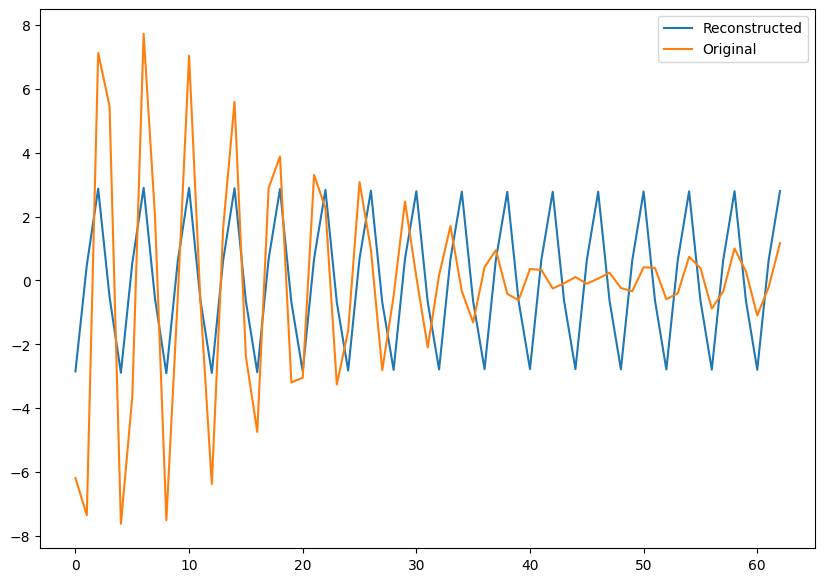

In [118]:
xreconstruct = Synthesis(N,delta,f,a,phi)
plt.figure(figsize=(10, 7))
plt.plot(xreconstruct.real, label='Reconstructed')
plt.plot(x.real, label='Original')
plt.legend()
plt.show()

- What we observe is that the reconstructed signal and the original one are quite different.
- This can be explained by the fact that the computed damping factors and a and phi have values that are different from what we should have found.

<hr style="border-top: 5px dotted #999;">


# <b> 3.2.2 MUSIC Method </b>

The length of the signal is 63.
The length of the Hankel matrix is 32.
The shape of the Hankel matrix is (32, 32).
The shape of the signal subspace is (32, 2).
The shape of the noise subspace is (32, 30).


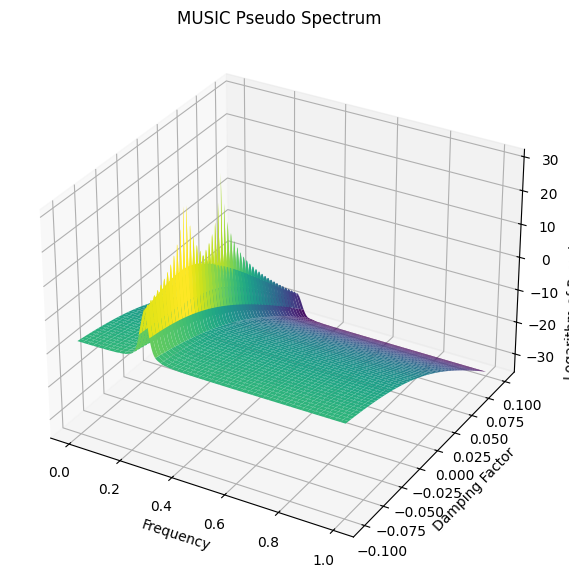

In [119]:
def MUSIC(x,n,K):
    # Step 1: Computation of the empirical covariance matrix
    ########################################################
    N = len(x) # length of the signal
    print(f"The length of the signal is {N}.")
    L = N - n + 1 # length of the Hankel matrix
    print(f"The length of the Hankel matrix is {L}.")
    X = hankel(x[:n], x[n-1:N]) # Construct the Hankel matrix
    print(f"The shape of the Hankel matrix is {X.shape}.")

    # Construct the empirical covariance matrix
    Rxx = (1/L) * (X @ X.conj().T)    

    # Step 2: Estimation of the signal subspace
    ########################################################
    # Diagonalize the matrix Rxx
    U1, Lambda, U2 = np.linalg.svd(Rxx)
    # extract from U1 an n x K basis of the signal subspace W
    W = U1[:, :K]
    print(f"The shape of the signal subspace is {W.shape}.")

    # compute the noise subspace as the orthogonal complement of W
    W_perp = U1[:, K:]
    print(f"The shape of the noise subspace is {W_perp.shape}.")

    # Step 3: MUSIC pseudo-spectrum calculation
    ########################################################
    # Generate a meshgrid of frequencies and damping factors
    frequencies = np.linspace(0, 1, 1000)
    damping_factors = np.linspace(-0.1, 0.1, 1000)
    F, D = np.meshgrid(frequencies, damping_factors)

    # Compute the pseudo spectrum for each combination of frequency and damping factor
    pseudo_spectrum = np.zeros_like(F)
    for i, f in enumerate(frequencies):
        for j, d in enumerate(damping_factors):            
            z = np.exp(d + 1j * 2 * np.pi * f)
            a = np.array([z**m for m in range(n)])

            pseudo_spectrum[j, i] = 1 / np.linalg.norm(W_perp.conj().T @ a)**2

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(F, D, 10 * np.log10(pseudo_spectrum), cmap='viridis')

    ax.set_xlabel('Frequency')
    ax.set_ylabel('Damping Factor')
    ax.set_zlabel('Logarithm of Pseudo Spectrum (dB)')
    ax.set_title('MUSIC Pseudo Spectrum')
    plt.show()

MUSIC(x, 32, 2)

- We remark that the MUSIC method makes the two poles clearly visible.

----
----
# <b> 4. Audio signals </b>

## <b> 4.1. Spectral analysis by Fourier transform

In [120]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
FsclocheA = int(wavefile.getframerate())
xclocheA = np.array(data)
num_samples_CLA = int(wavefile.getnframes())
print(f"FsclocheA = {FsclocheA}, num_samples = {num_samples_CLA}")

FsclocheA = 8000, num_samples = 99414


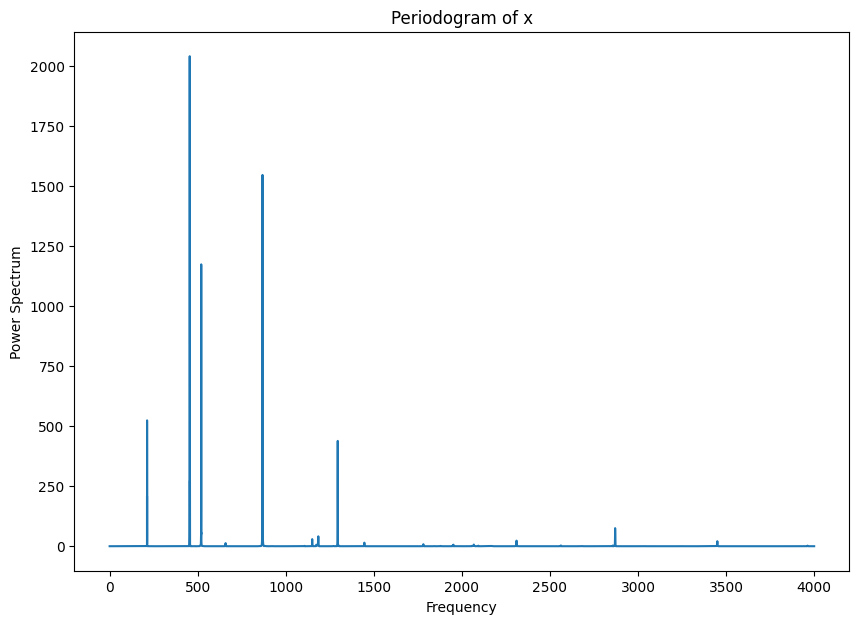

In [121]:
# Look at the periodogram of the signal ClocheA.WAV

frequencies, power_spectrum = signal.periodogram(xclocheA, FsclocheA)

plt.figure(figsize=(10, 7))
plt.plot(frequencies, power_spectrum[0])  
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')
plt.title('Periodogram of x')
plt.show()

In [122]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheB.WAV')
FsclocheB = int(wavefile.getframerate())
xclocheB = np.array(data)
num_samples = int(wavefile.getnframes())
print(f"FsclocheB = {FsclocheB}, num_samples = {num_samples}")

FsclocheB = 8000, num_samples = 99414


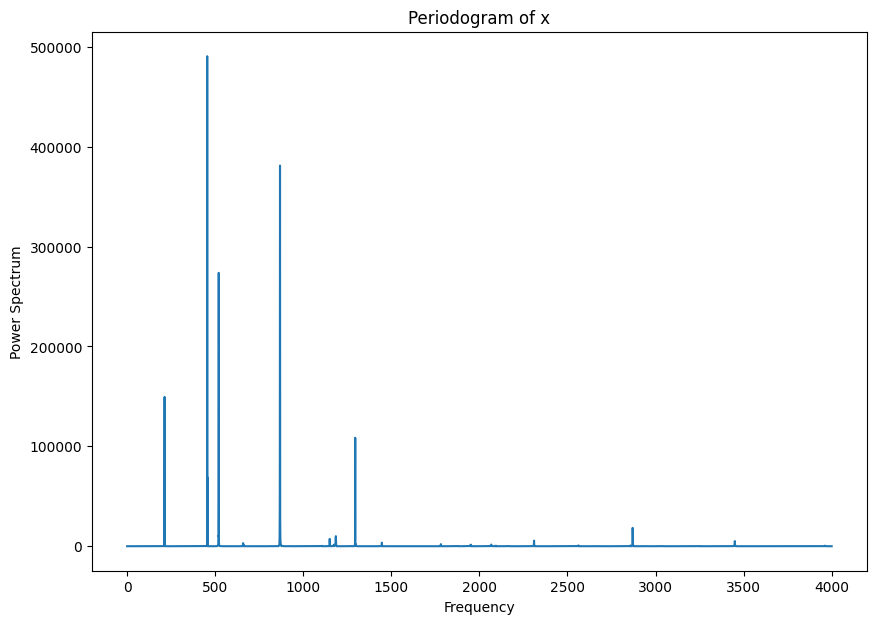

In [123]:
# Look at the periodogram of the signal ClocheB.WAV

frequencies, power_spectrum = signal.periodogram(xclocheB, FsclocheB)

plt.figure(figsize=(10, 7))
plt.plot(frequencies, power_spectrum[0])  
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')
plt.title('Periodogram of x')
plt.show()


In [124]:
print(FsclocheB)

8000


In [125]:
selected_frequencies = frequencies[power_spectrum[0] > 10000]
selected_frequencies_final = []
for i in range(len(selected_frequencies)):
    if i == 0 or selected_frequencies[i] - selected_frequencies[i-1] >= 2:
        selected_frequencies_final.append(round(selected_frequencies[i]))
print(selected_frequencies_final)

ratios = [FsclocheB / freq for freq in selected_frequencies_final]
print(ratios)



[212, 454, 519, 866, 1185, 1294, 2869]
[37.735849056603776, 17.621145374449338, 15.414258188824663, 9.237875288683602, 6.751054852320675, 6.182380216383308, 2.788428023701638]


- The ratio of the eigenvalues is not close to what has been obtained in the introduction as it is claimed that the ratios are 0.5, 1, 1.2 ... and ours are higher.

----
## <b>4.2: High resolution method </b>

In [126]:
K = 54
n = 512
l = 1024 # 2*n 
N = 1535

# extract a signal from xclocheA
# we start at the 10000th sample and extract 1535 samples
xextractClA = xclocheA[10000:10000+N+1]

# apply the ESPRIT method to estimate the frequencies and damping factors
delta_k, f_k = ESPRIT(xextractClA, l, K)
# estimate the amplitudes and phases
a_k, phi_k = LeastSquares(xextractClA, delta_k, f_k)

# listen to the signal reconstructed from the estimated parameters
xreconstructedClA = Synthesis(num_samples_CLA, delta_k, f_k, a_k, phi_k)
write('reconstructed_bell.wav', FsclocheA, np.array(xreconstructedClA, dtype=np.int16)) # to write a new wave file

The length of the signal is 0.
The length of the Hankel matrix is -1023.
The shape of the Hankel matrix is (0, 0).
The shape of the signal subspace is (0, 0).
The shape of Wdown is (0, 0).
The shape of Wup is (0, 0).
The shape of Phi is (0, 0).
The eigenvalues of Phi are [].
The estimated frequencies are [].
The estimated damping factors are [].
The shape of the Vandermonde matrix is (0, 0).


C:\Users\matte\AppData\Local\Temp\ipykernel_24708\3715700166.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  write('reconstructed_bell.wav', FsclocheA, np.array(xreconstructedClA, dtype=np.int16)) # to write a new wave file


In [127]:
IPython.display.Audio('reconstructed_bell.wav')

- Unfortunately the reconstructed signal is not working, I can not comment on its synthesis.

----
----
# <b> Conclusion </b>
- This lab was nice as it provided the opportunity to implement common methods such as MUSIC or ESPRIT.
- However, slight problems have been problematic to visualize all the expected outcome.
----
----